In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image
from skimage.io import imshow, imread
from skimage.transform import resize
import glob
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

In [3]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.load_weights('models/color_softmax_car_cnn_30_epochs.h5')

In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 148, 148, 32)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 148, 148, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 74, 74, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 72, 72, 32)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

1/1 [==============================] - 0s
[0]
1/1 [==============================] - 0s
[[  1.00000000e+00   1.30230727e-37]]
1/1 [==============================] - 0s
[0]
1/1 [==============================] - 0s
[[ 1.  0.]]
1/1 [==============================] - 0s
[0]
1/1 [==============================] - 0s
[[ 1.  0.]]
1/1 [==============================] - 0s
[0]
1/1 [==============================] - 0s
[[ 1.  0.]]


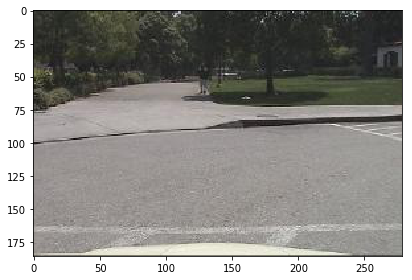

In [6]:
img_list = ['./dataset/ColorCars/BackgroundOrigins/image_1370.jpg',
            './dataset/ColorCars/BackgroundOrigins/image_1350.jpg',
            './dataset/ColorCars/BackgroundOrigins/image_1320.jpg',
            './dataset/ColorCars/BackgroundOrigins/image_1230.jpg']

for ip in img_list:
    img = image.load_img(ip, target_size=(150,150))
    img = image.img_to_array(img)
    img /= 255
    img = img.reshape((1,)+img.shape)
    print(model.predict_classes(img))
    print(model.predict_proba(img))

imshow(img_list[0])

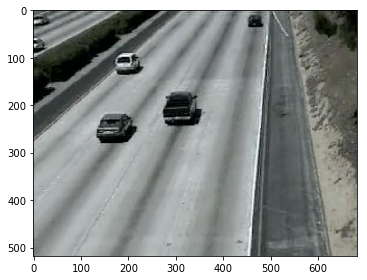

In [7]:
image_path = './dataset/car_test1.jpg'
im = imread(image_path)
min_wdw_sz = (150, 150)
step_size = (30, 30)
downscale = 1.25
imshow(image_path)

In [9]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window

    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [8]:
def preprocessing_image(img):
    img = resize(img, (150,150))
    img /= 255
    img = img.reshape((1,)+img.shape)
    return img

<class 'numpy.ndarray'> (1, 150, 150, 3)
1/1 [==============================] - 0s
<class 'numpy.ndarray'> [1] 1
<class 'numpy.ndarray'> [[  8.12994413e-38   1.00000000e+00]]


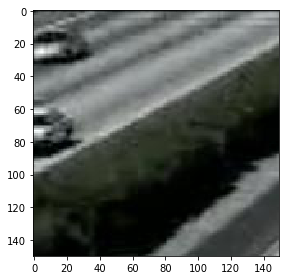

In [11]:
for (x, y, im_window) in sliding_window(im, min_wdw_sz, step_size):
    if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
        continue
    arr = preprocessing_image(im_window)
    print(type(arr), arr.shape)
    pred = model.predict_classes(arr)
    pred2 = model.predict_proba(arr)
    print(type(pred), pred, pred[0])
    print(type(pred2), pred2)
    imshow(im_window)
    break

In [14]:
# List to store the detections
detections = []
scale = 0
for (x, y, im_window) in sliding_window(im, min_wdw_sz, step_size):
    # This list contains detections at the current scale
    cd = []
    if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
        continue
    arr = preprocessing_image(im_window)
    # print(type(arr), arr.shape)
    pred = model.predict_classes(arr)
    if pred[0] == 0:
        confi_score = model.predict_proba(arr)[0][0]
        print("Scale : {}, Detection Location -> ({}, {}) | Confidence Socre : {}".format(scale,x,y,confi_score))
        detections.append((x,y,confi_score, int(min_wdw_sz[0]*(downscale**scale)), int(min_wdw_sz[1]*(downscale**scale))))
        cd.append(detections[-1])
scale += 1

1/1 [==============================] - 0s


In [15]:
len(detections)

0